In [2]:
import cbpro
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import ta
from datetime import datetime, timedelta
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [152]:
import json
with open("config.json") as json_data_file:
    config = json.load(json_data_file)
client = cbpro.AuthenticatedClient(config["api_public"], config["api_secret"], config["passphrase"])

## DATA RETRIEVAL AND CLEANING


In [48]:
def getminutedata(symbol, interval_min=1, lookback=24*60):
    '''
    Method to obtain minute data from the Coinbase Pro API
    
    Parameters
    ----------
    
    symbol : str
         Symbol of the currency, e.g., "BTC-EUR", "DOT-EUR", "BTC-USD", "DOT-USD"
    
    interval_min : int
            The interval in minutes between the retrieved timestamps, can only be in the following range [1, 5, 15, 60, 360, 1440]
    
    lookback : int
        The number of minutes to lookback starting from the current timestamp
        
    Returns
    -------
    Pandas Dataframe
        a dataframe with the trade data

    '''
    
    MAX_REQUESTS = 300  # can only request 300 timestamps each time
    interval_sec = interval_min*60  # interval in seconds
    
    end = pd.to_datetime(client.get_time()["epoch"], unit ="s")  # end date
    start = end - timedelta(minutes=lookback)  # start date
    current_start = start
    
    try:
        # one request can only retrieve up to 300 timestamps: use for loop to obtain the desired range with multiple requests
        dataframes = []
        n_timestamps = int(lookback/interval_min)
        delta = timedelta(minutes=min(lookback, MAX_REQUESTS)*interval_min)  # time between each timestamp
        for i in range(int(n_timestamps/MAX_REQUESTS)):    
            current_end = current_start + delta
            dataframes.append(pd.DataFrame(client.get_product_historic_rates(symbol, current_start.isoformat(), current_end.isoformat(), interval_sec))[::-1])
            current_start = current_end
        dataframes.append(pd.DataFrame(client.get_product_historic_rates(symbol, current_start.isoformat(), end, interval_sec))[::-1])
        df = pd.concat(dataframes)
    except:
        print("ERROR:")
        print(client.get_product_historic_rates(symbol, current_start.isoformat(), current_end.isoformat(), interval_sec))  # should print what error we got
        
    # clean dataframe
    df.columns = ["Time", "Low", "High", "Open", "Close", "Volume"]
    df = df.astype(float)
    df = df.set_index("Time")
    df.index = pd.to_datetime(df.index, unit ="s")
    
    # add some measures
    df['RSI'] = ta.momentum.rsi(df.Close, window=10)
    df['SMA200'] = ta.trend.sma_indicator(df.Close, window=200)
    df['EMA200'] = ta.trend.ema_indicator(df.Close, window=200)
    df['SMA100'] = ta.trend.sma_indicator(df.Close, window=100)
    df['EMA100'] = ta.trend.ema_indicator(df.Close, window=100)
    df['SMA50'] = ta.trend.sma_indicator(df.Close, window=50)
    df['EMA50'] = ta.trend.ema_indicator(df.Close, window=50)

    return df

    
    

## Strategies

The function for each strategy should be able to take a **pandas dataframe** as input and returns **"BUY", "SELL", "NO TRADE"** to indicate whether and what kind of trade will happen.

In [86]:
def RSI_SMA_strategy(df):
    df["Signal"] = np.where((df.Close > df.EMA50) & (df.RSI < 30), True, False)  # RSI SMA strategy
    buying_dates = []
    selling_dates = []
    for i in range(len(df)):
        # buy
        if df.iloc[i].Signal:
            buying_dates.append(df.iloc[i+1].name) # buy next open
            for j in range(1,61):
                if df["RSI"].iloc[i+j] > 70:
                    selling_dates.append(df.iloc[i+j].name)
                    break
                elif j == 60:  #sell after 60 mins
                    selling_dates.append(df.iloc[i+j].name)
    actual_trades = pd.DataFrame({"buying_dates": buying_dates, "selling_dates": selling_dates})
    actual_trades = actual_trades[actual_trades.buying_dates > actual_trades.selling_dates.shift(1)]
    
    return actual_trades
    


In [139]:
def RSI_SMA_strategy(row, entried = False, stop_loss=0.975):
    signal = (row.Close > row.EMA100) & (row.RSI < 30)  # RSI SMA strategy
    
    # not entried yet so try to buy
    if not entried:
        if signal:
            return "BUY" # buy next open
        
    # entried into a buy position so try to sell at a good price
    if entried:
        price_change = row.last_buying_price/row.Open
        if row.RSI > 50:
            return "SELL" # sell next open
        elif price_change < stop_loss:
            return "SELL"

    return "NO TRADE"  # No trade

    

## Backtesting

In [142]:
def backtest(strategy, df):
    '''
    Backtest your strategy with this function
    
    Parameters
    ----------
    
    strategy : func
        function that returns "BUY", "SELL", "NO TRADE"
        
    df : pandas dataframe
        dataframe containing the trading data
    
    Returns
    -------
    Pandas dataframe
        dataframe containing the buying/selling dates with the profits, returns and open prices
    
    '''
    
    buying_dates = []
    buying_open_prices = []
    selling_dates = []
    selling_open_prices = []
    entried = False
    
    # check per row whether we want to buy or sell the stock
    for i in range(len(df)-1):
        row = df.iloc[i].copy()
        next_row = df.iloc[i+1].copy()
        if entried:
            row["last_buying_price"] = buying_open_prices[-1]
        
        action = strategy(row, entried)
        timestamp = next_row.name
        
        if action == "BUY":
            entried = True
            buying_dates.append(timestamp)
            buying_open_prices.append(next_row.Open)
        elif action == "SELL":
            entried = False
            selling_dates.append(timestamp)
            selling_open_prices.append(next_row.Open)
    
    # if we have more buying dates, then it means that the last selling date has not taken place yet
    if len(buying_dates) > len(selling_dates):
        buying_dates = buying_dates[:-1]
        buying_open_prices = buying_open_prices[:-1]
        
    actual_trades = pd.DataFrame({"buying_date": buying_dates, "selling_date": selling_dates, "buying_open_price": buying_open_prices, "selling_open_price": selling_open_prices})
    
    
        
    # plot results
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,20))
    ax=axes[0]
    ax2=axes[1]
    df.plot(kind="line", y="Open", ax=ax, alpha =0.7)
    #df.plot(kind="line", y="SMA200", c="orange", alpha =1, ax=ax, label = "SMA200")
    df.plot(kind="line", y="EMA200", c="purple", alpha =1, ax=ax, label = "EMA200")
    #df.plot(kind="line", y="SMA50", alpha =1, ax=ax, label = "SMA50")
    df.plot(kind="line", y="EMA100", alpha =1, ax=ax, label = "EMA100")
    df.plot(kind="line", y="EMA50", alpha =1, ax=ax, label = "EMA50")
    df.plot(kind="line", y="RSI", alpha =1, ax=ax2, label = "RSI")
    ax2.set_ylim((0,100))
    ax2.axhline(50, c="black")
    ax2.axhline(30, c="black")
    actual_trades.plot(kind="scatter", s=20, c="red", x="buying_date", y="buying_open_price", ax=ax, label="BUY")
    actual_trades.plot(kind="scatter", s=20, c="green", x="selling_date", y="selling_open_price", ax=ax, label="SELL")

    #myFmt = mdates.DateFormatter(' %H:%M:')

    #ax.xaxis.set_major_formatter(myFmt)

    ax.set_xlabel("time")
    ax.set_ylabel("price")

    plt.gcf().autofmt_xdate()
    
    # if there are actual trades retrieve the performance measures
    if len(actual_trades) > 0:
        # performance measures
        profits = df.loc[actual_trades.selling_date].Open.values - df.loc[actual_trades.buying_date].Open.values
        winning_rate = np.sum([profits>0])/len(profits)
        returns = (df.loc[actual_trades.selling_date].Open.values - df.loc[actual_trades.buying_date].Open.values)/df.loc[actual_trades.buying_date].Open.values

        # adding performance measures to dataframe
        actual_trades["profit"] = profits
        actual_trades["return"] = returns

        # print results
        print("ACTUAL TRADES:")
        print(actual_trades)
        print("\n")
        print("profit: %.2f" % sum(profits)) 
        print("average returns:  %.6f" % (sum(returns)/max(1, len(returns))))
        print("winning rate:  %.2f" % (winning_rate))
        return actual_trades
    else:

        print("NO TRADES HAVE TAKEN PLACE")
        return None

ACTUAL TRADES:
          buying_date        selling_date  buying_open_price  selling_open_price  profit    return
0 2021-11-29 09:45:00 2021-11-29 13:15:00             31.477              31.745   0.268  0.008514


profit: 0.27
average returns:  0.008514
winning rate:  1.00


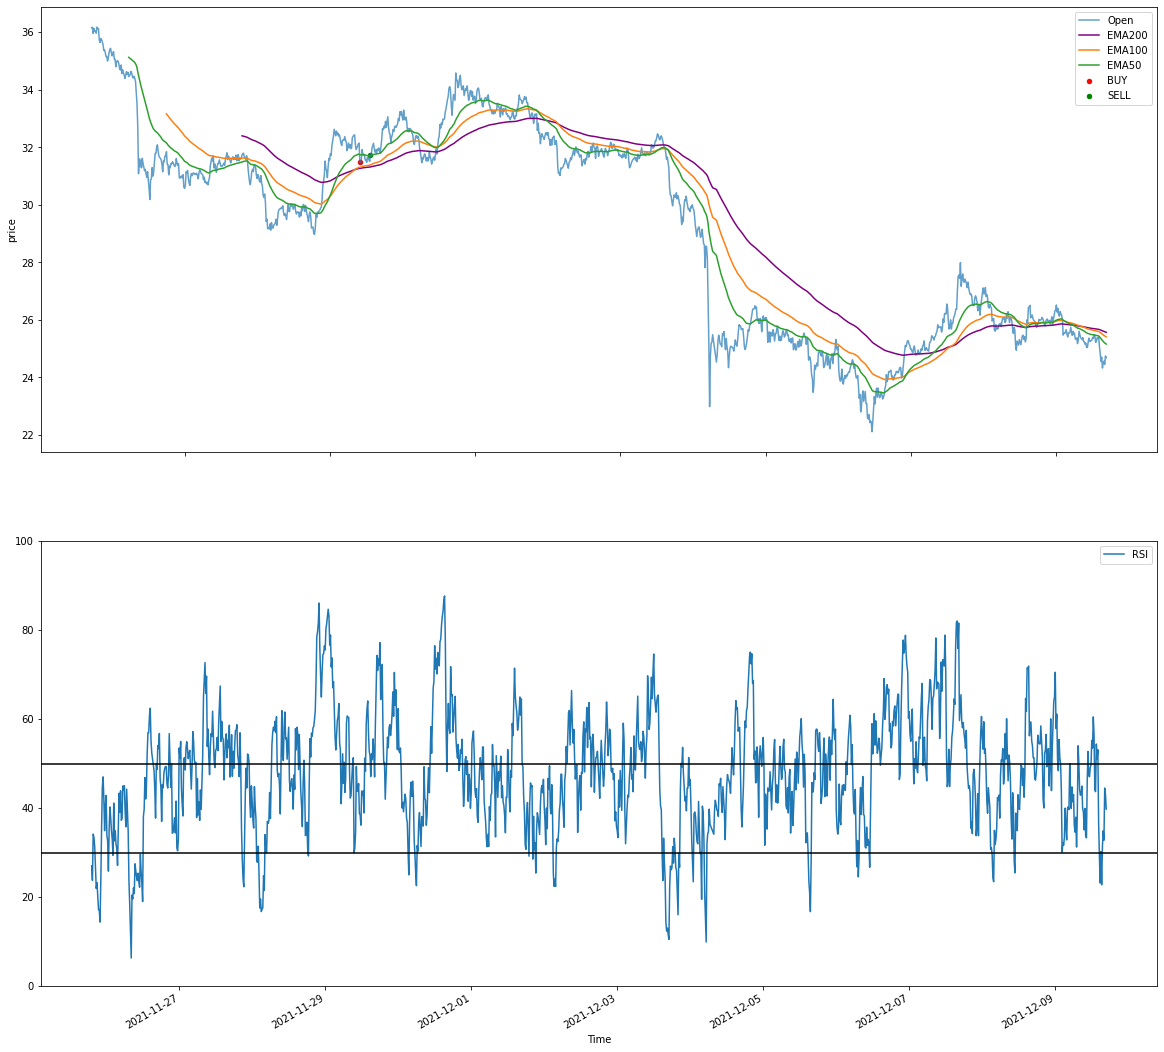

In [146]:
#df = getminutedata("BTC-EUR", lookback=600)
df = getminutedata("DOT-EUR", interval_min=15, lookback=60*24*7*2)
results = backtest(RSI_SMA_strategy, df)

In [134]:
df

,Low,High,Open,Close,Volume,RSI,SMA200,EMA200,SMA100,EMA100,SMA50,EMA50
Time,,,,,,,,,,,,
2021-12-08 14:22:00,25.610,25.651,25.641,25.610,82.117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-08 14:24:00,25.597,25.642,25.597,25.619,224.168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-08 14:25:00,25.654,25.761,25.657,25.761,810.792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-08 14:26:00,25.761,25.844,25.761,25.844,315.422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-08 14:27:00,25.829,25.880,25.855,25.851,128.631,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-09 14:17:00,25.374,25.409,25.374,25.397,193.537,60.225531,25.325975,25.316458,25.33273,25.324457,25.31578,25.331569
2021-12-09 14:18:00,25.288,25.367,25.367,25.288,100.436,40.976600,25.325265,25.316175,25.33175,25.323735,25.31876,25.329860
2021-12-09 14:19:00,25.229,25.282,25.282,25.229,47.423,34.369866,25.324470,25.315307,25.32968,25.321859,25.32024,25.325905


## TRADING BOT

In [15]:
# simple strategy
def strategytest(symbol, qty=0, entried=False):
    while not entried:
        df = getminutedata(symbol)
        cumulret = (df.Open.pct_change()+1).cumprod() - 1
        if not entried:
            if cumulret[-1] < - 0.001:
                #  order = client.create_order(symbol=symbol, side ="BUY", type="MARKET", quantity=qty)
                #  print(order)
                print("BUY at %.3f" % df.Open[-1])
                transactTime = df.index[-1]
                entried=True
            else:
                print("no trade")
    if entried:
        while True:
            df = getminutedata(symbol)
            # sincebuy = df.loc[df.index>pd.to_datetime(order["transactTime"], unit="ms")]
            sincebuy = df.loc[df.index > transactTime]
            if len(sincebuy > 0):
                sincebuyret = (sincebuy.Open.pct_change() + 1).cumprod() - 1
                if sincebuyret[-1] > 0.0015 or sincebuyret[-1] < -0.0015:
                    #order = client.create_order(symbol=symbol, side ="SELL", type="MARKET", quantity=qty)
                    #print(order)
                    print("SELL at %.3f" % df.Open[-1])
                    break
                    
                

In [19]:
def test(x):
    return 1 + x

def test2(func, x):
    print(func(x))
    
test2(test, 10)
    

11


In [21]:
a = [1,2,3,4]
a=a[:-1]

In [22]:
a

[1, 2, 3]

In [90]:
a = df.iloc[1]

In [92]:
a["test"] = 1

In [94]:
df

,Low,High,Open,Close,Volume,RSI,SMA200
Time,,,,,,,
2021-12-01 19:42:00,50824.21,50877.18,50830.15,50862.58,0.297527,NaN,NaN
2021-12-01 19:43:00,50829.42,50885.73,50845.35,50885.73,0.244459,NaN,NaN
2021-12-01 19:44:00,50826.30,50889.24,50889.24,50861.72,0.815693,NaN,NaN
2021-12-01 19:45:00,50831.28,50882.09,50860.47,50836.40,0.422833,NaN,NaN
2021-12-01 19:46:00,50818.50,50869.07,50840.61,50849.68,0.921497,NaN,NaN
...,...,...,...,...,...,...,...
2021-12-08 19:37:00,44724.33,44779.26,44763.34,44736.61,0.175091,57.303593,44509.01430
2021-12-08 19:38:00,44725.51,44749.67,44745.67,44725.58,0.457212,55.470513,44509.41610
2021-12-08 19:39:00,44712.21,44739.53,44712.21,44737.36,0.138402,57.099036,44509.86885
